In [ ]:
!pip install pytesseract
import pytesseract

In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


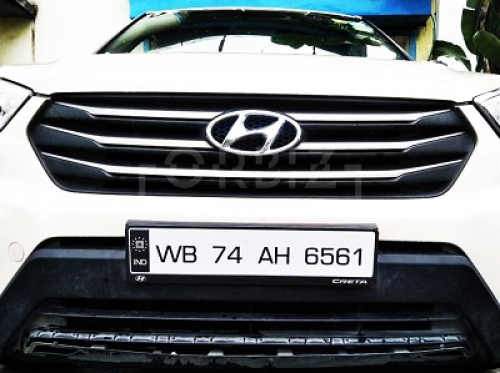

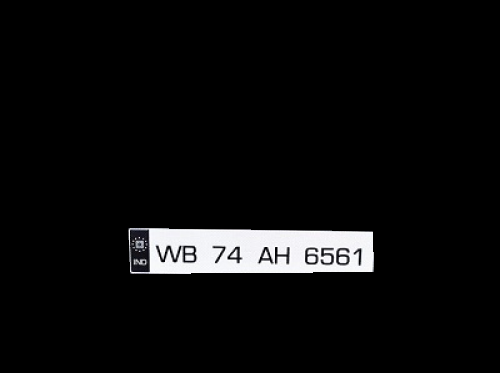

Image 1
we 74 aH 6561




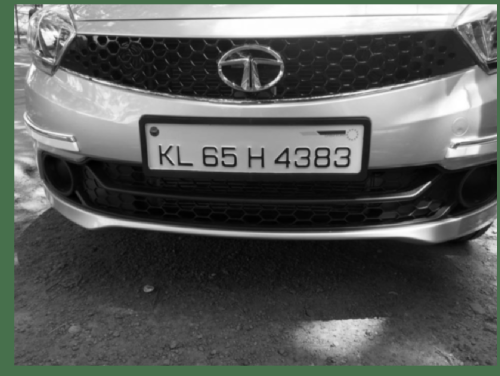

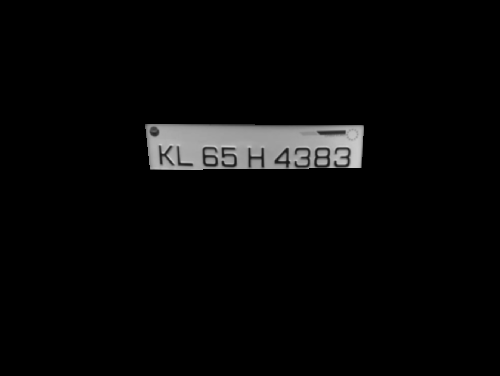

Image 2
KL 654 4383




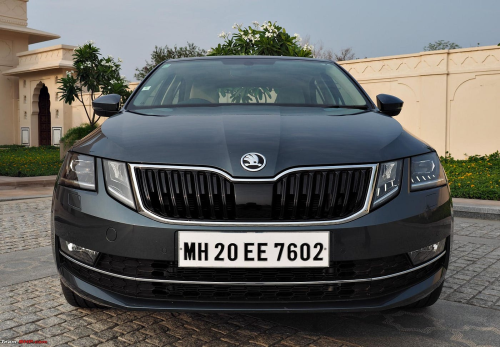

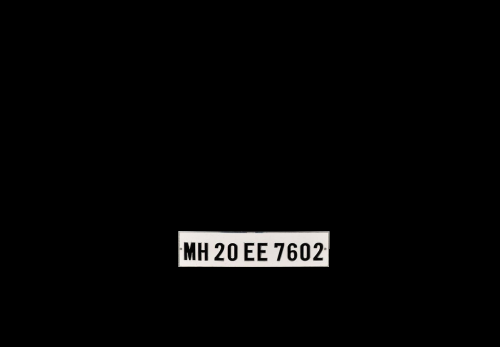

Image 3
MH 20 EE 7602




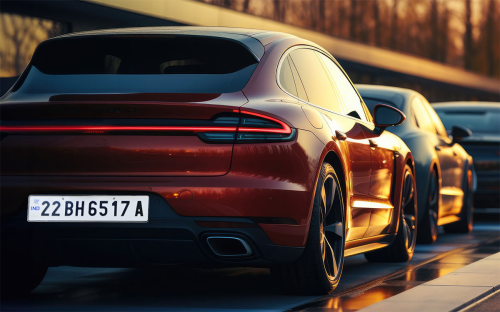

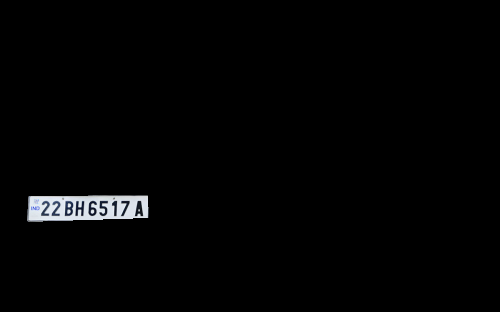

Image 4
22BH6517A




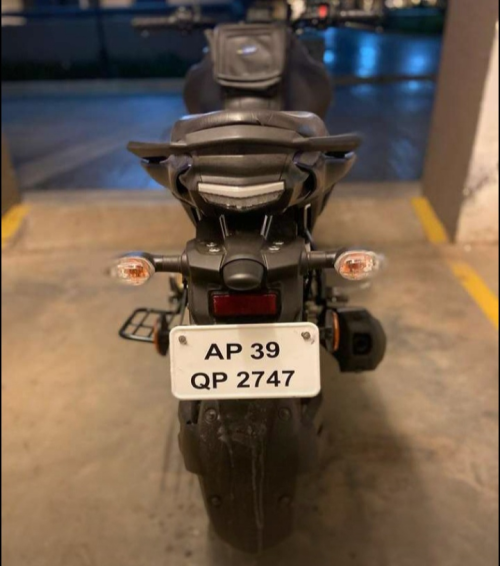

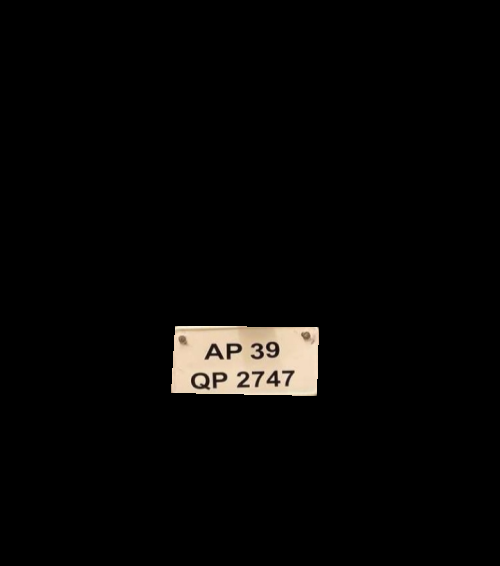

Image 5
AP 39
QP 2747




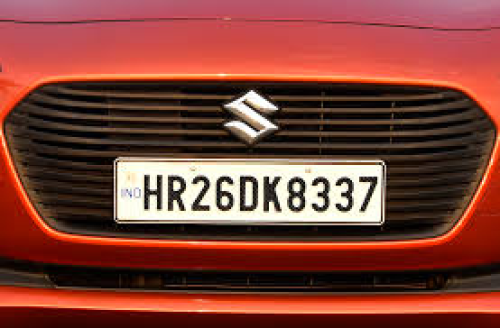

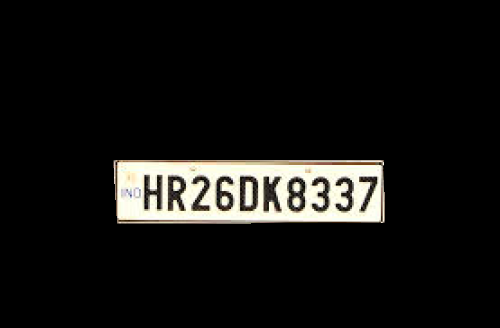

Image 6
HR26DK8337|




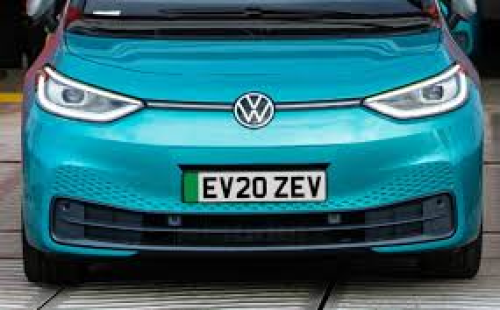

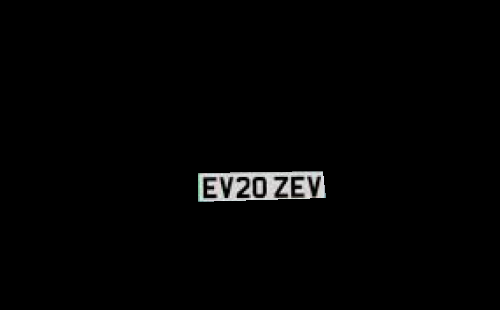

Image 7
EV20 ZEV




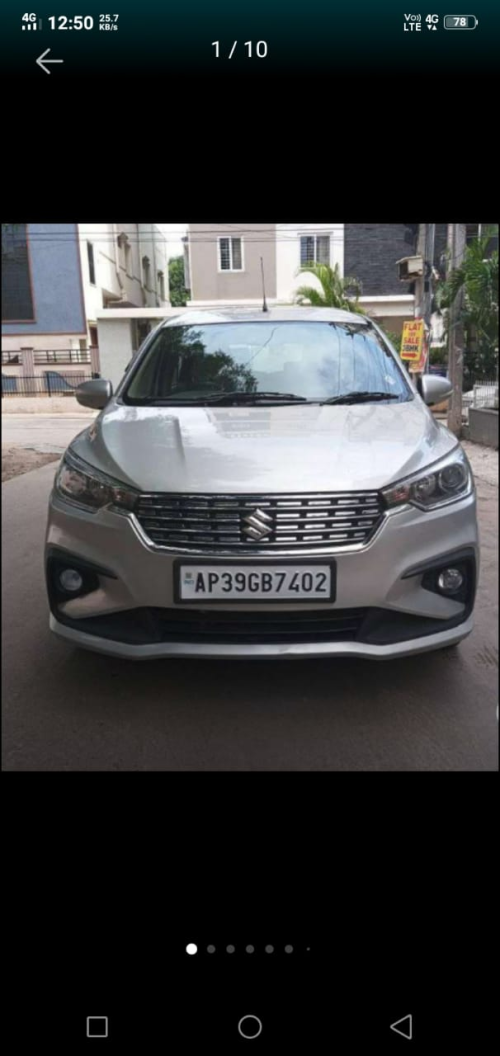

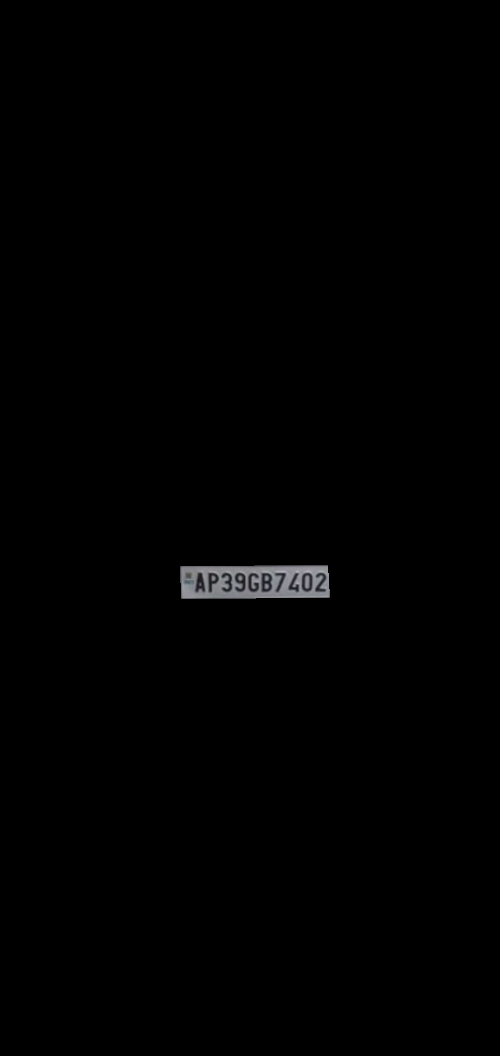

Image 8
AP39GB7402




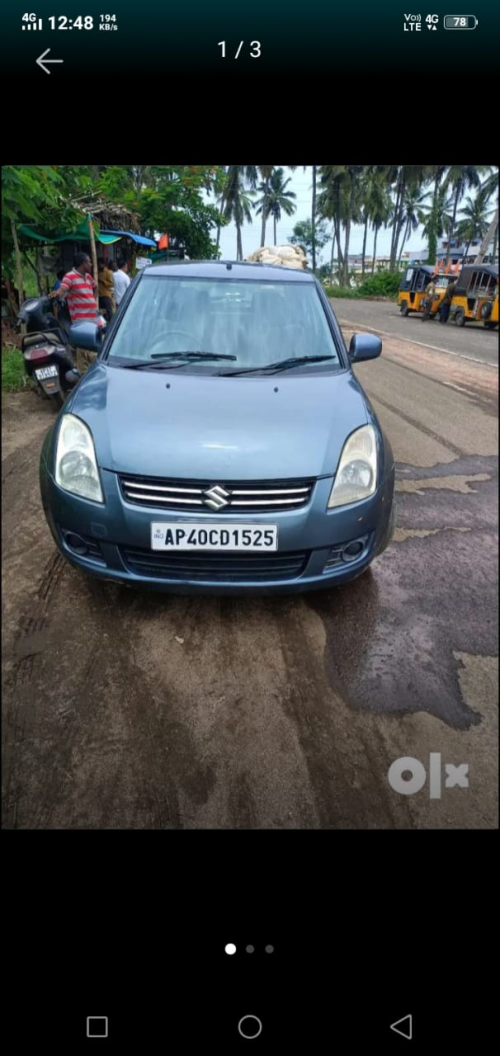

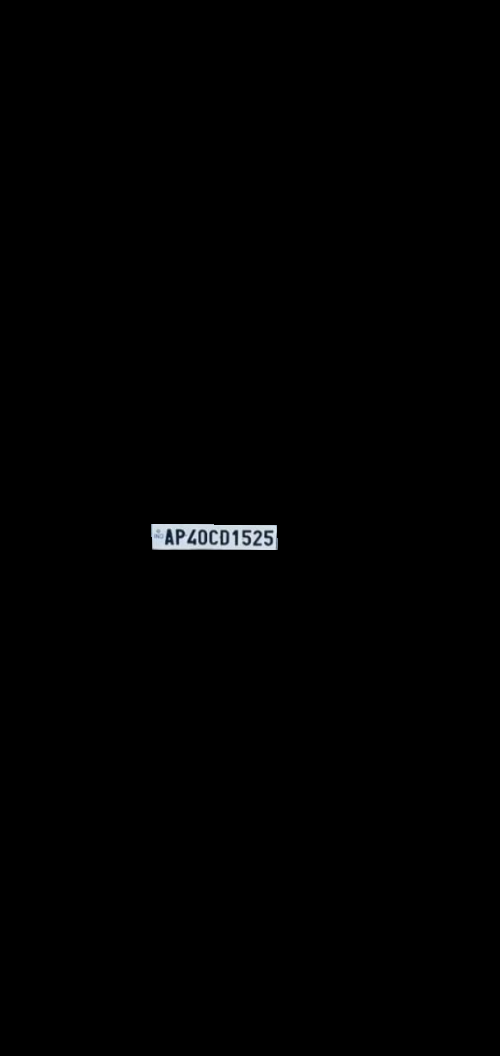

Image 9
AP4OCD1525




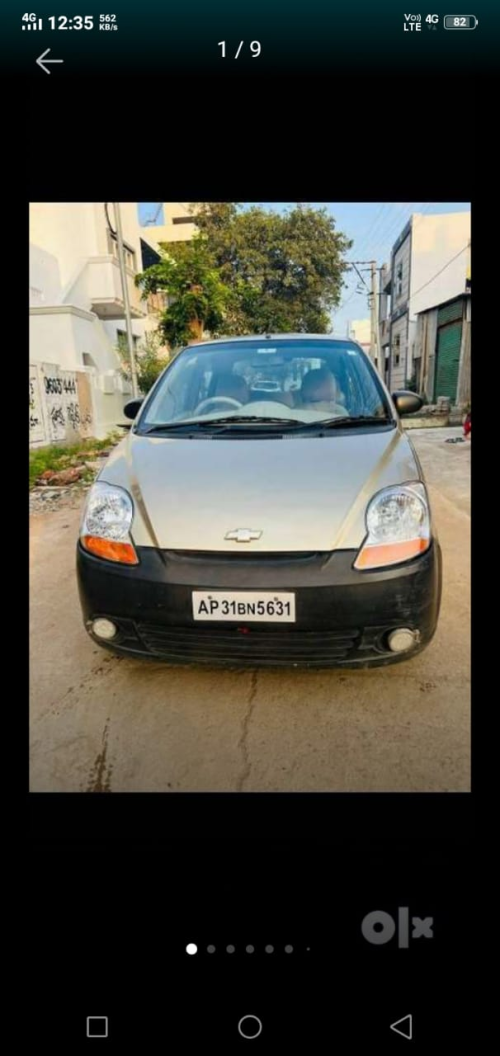

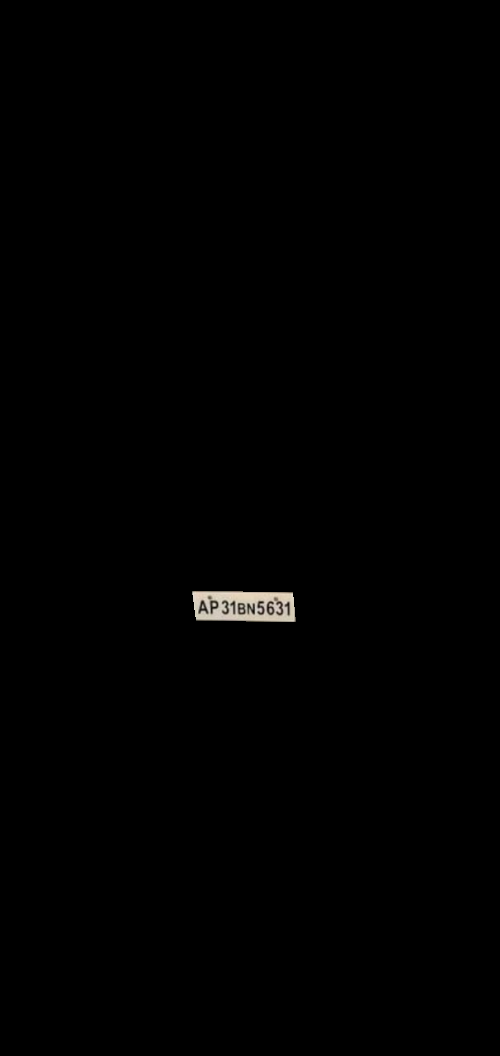

Image 10
AP 318N5631




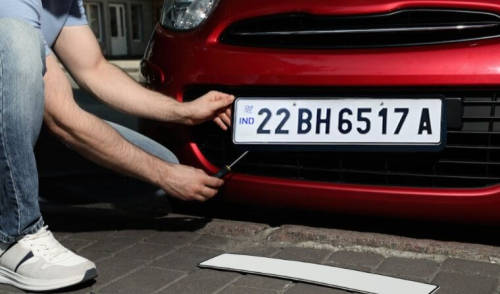

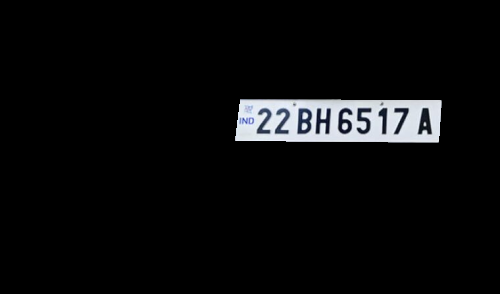

Image 11
22BH6517A




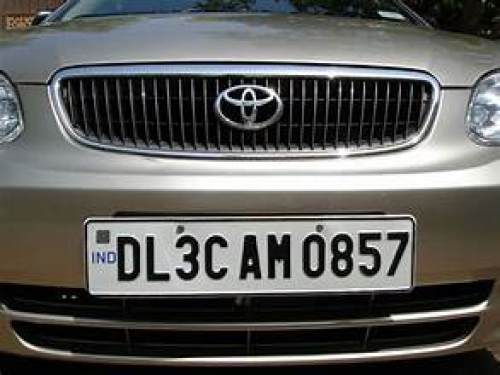

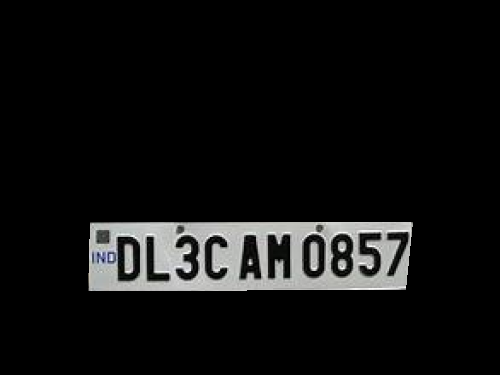

Image 12
"DL3C AM 0857,




In [ ]:
import numpy as np
import os
import datetime
import cv2
import imutils
import pytesseract
import pandas as pd
import random as r
from google.colab.patches import cv2_imshow  # Importing cv2_imshow for displaying images

file_path = 'vehicles.csv'

for i in range(1, 13):
    image = cv2.imread(f'Images/vehicle{i}.jpg')

    if image is None:
        print(f"Image not found: Images/vehicle{i}.jpg")
        continue

    image = imutils.resize(image, width=500)
    cv2_imshow(image)  # Display the original image using cv2_imshow

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 170, 200)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and find the largest one that is a quadrilateral
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    NumberPlateCnt = None

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            NumberPlateCnt = approx
            break

    if NumberPlateCnt is None:
        print("Number plate not found")
        continue

    # Masking the part other than the number plate
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [NumberPlateCnt], 0, 255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)
    cv2_imshow(new_image)  # Display the final image using cv2_imshow

    # Configuration for tesseract
    config = ('-l eng --oem 1 --psm 3')

    # Run tesseract OCR on image
    text = pytesseract.image_to_string(new_image, config=config)

    # Generate random times
    hh = r.randint(12, 19)
    mm = r.randint(15, 45)
    intime = f"{hh:02d}:{mm:02d}"

    hh_out = hh + r.randint(1, 3)
    mm_out = mm + r.randint(-6, 13)
    # Adjust for overflow
    if mm_out >= 60:
        hh_out += 1
        mm_out -= 60

    outtime = f"{hh_out:02d}:{mm_out:02d}"

    # Calculate total time
    in_time_obj = datetime.datetime.strptime(intime, '%H:%M')
    out_time_obj = datetime.datetime.strptime(outtime, '%H:%M')
    total_time_obj = out_time_obj - in_time_obj
    total_time_minutes = total_time_obj.total_seconds() / 60  # Convert total seconds to minutes

    raw_data = {
        'Vehicle_Number': [text.strip()],
        'In_Time': [intime],
        'Out_Time': [outtime],
        'Total_Time': [total_time_minutes]  # Store total time in minutes
    }

    df = pd.DataFrame(raw_data, columns=['Vehicle_Number', 'In_Time', 'Out_Time','Total_Time'])

    # Append to CSV file if it exists, otherwise create it
    if os.path.isfile(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, mode='w', header=True, index=False)

    # Print recognized text
    print(f"Image {i}")
    print(text)
    print()

Peak hour: 19:00 - 20:00
Number of vehicles: 11
Vehicles present during peak hour: ['EV20 ZEV', 'AP39GB7402', 'AP4OCD1525', 'AP 318N5631', 'we 74 aH 6561', 'MH 20 EE 7602', '22BH6517A', 'AP 39\nQP 2747', 'HR26DK8337|']

List of vehicles present in each hour:
00:00 - 01:00: No vehicles
01:00 - 02:00: No vehicles
02:00 - 03:00: No vehicles
03:00 - 04:00: No vehicles
04:00 - 05:00: No vehicles
05:00 - 06:00: No vehicles
06:00 - 07:00: No vehicles
07:00 - 08:00: No vehicles
08:00 - 09:00: No vehicles
09:00 - 10:00: No vehicles
10:00 - 11:00: No vehicles
11:00 - 12:00: No vehicles
12:00 - 13:00: No vehicles
13:00 - 14:00: ['we 74 aH 6561', 'MH 20 EE 7602', 'HR26DK8337|']
14:00 - 15:00: ['MH 20 EE 7602', 'HR26DK8337|', '"DL3C AM 0857,', 'AP 318N5631', '22BH6517A']
15:00 - 16:00: ['MH 20 EE 7602', '22BH6517A', 'AP 39\nQP 2747', '"DL3C AM 0857,', 'AP 318N5631']
16:00 - 17:00: ['MH 20 EE 7602', '22BH6517A', 'AP 39\nQP 2747', '"DL3C AM 0857,', 'KL 654 4383', 'AP4OCD1525', 'AP 318N5631']
17:00 - 

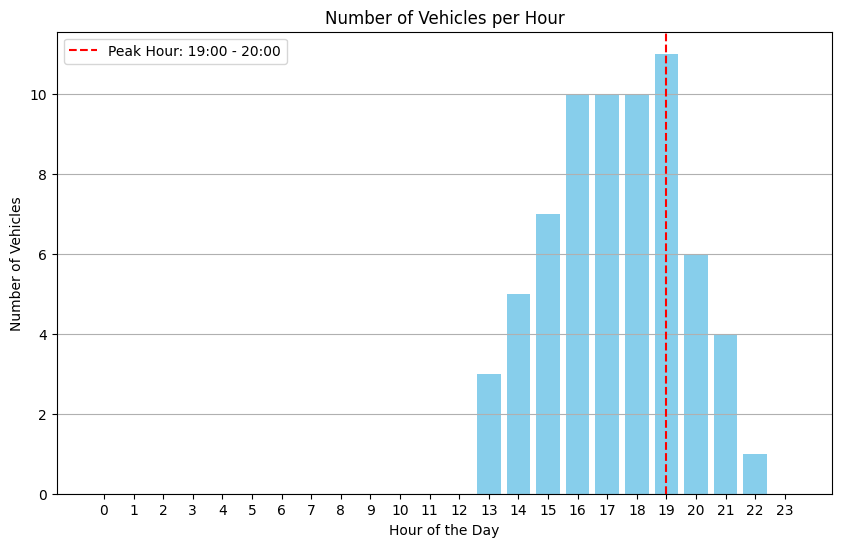

In [ ]:
import matplotlib.pyplot as plt
# Load the CSV file
file_path = 'vehicles.csv'
df = pd.read_csv(file_path)

# Initialize a dictionary to keep track of vehicle counts and vehicle lists per hour
hourly_counts = {hour: 0 for hour in range(24)}
hourly_vehicles = {hour: [] for hour in range(24)}

# Process each row to count vehicles per hour and store vehicle numbers
for _, row in df.iterrows():
    in_time = datetime.datetime.strptime(row['In_Time'], '%H:%M')
    out_time = datetime.datetime.strptime(row['Out_Time'], '%H:%M')
    vehicle_number = row['Vehicle_Number']

    # Increment counts and add vehicle numbers for each hour the vehicle is present
    current_time = in_time
    while current_time < out_time:
        hourly_counts[current_time.hour] += 1
        if vehicle_number not in hourly_vehicles[current_time.hour]:
            hourly_vehicles[current_time.hour].append(vehicle_number)
        current_time += datetime.timedelta(hours=1)
        if current_time.minute < in_time.minute:
            current_time -= datetime.timedelta(minutes=current_time.minute)
            current_time += datetime.timedelta(hours=1)

# Find the peak hour
peak_hour = max(hourly_counts, key=hourly_counts.get)
peak_count = hourly_counts[peak_hour]

# Print the peak hour and the number of vehicles present during that hour
print(f"Peak hour: {peak_hour:02d}:00 - {peak_hour+1:02d}:00")
print(f"Number of vehicles: {peak_count}")
print(f"Vehicles present during peak hour: {hourly_vehicles[peak_hour]}")

# Print the list of vehicles for each hour
print("\nList of vehicles present in each hour:")
for hour in range(24):
    if hourly_vehicles[hour]:
        print(f"{hour:02d}:00 - {hour+1:02d}:00: {hourly_vehicles[hour]}")
    else:
        print(f"{hour:02d}:00 - {hour+1:02d}:00: No vehicles")

# Create a bar chart for vehicle counts per hour
hours = list(hourly_counts.keys())
counts = list(hourly_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(hours, counts, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles per Hour')
plt.xticks(hours)
plt.grid(axis='y')

# Highlight the peak hour
plt.axvline(x=peak_hour, color='r', linestyle='--', label=f'Peak Hour: {peak_hour:02d}:00 - {peak_hour+1:02d}:00')
plt.legend()

# Show the plot
plt.show()


In [ ]:
rows = 5
cols = 10

# Create an empty parking lot matrix initialized with zeros
parking_lot = np.zeros((rows, cols), dtype=object)
parking_times = np.zeros((rows, cols), dtype=object)

# Load the CSV file to get the vehicle names
file_path = 'vehicles.csv'
df = pd.read_csv(file_path)

# Extract vehicle names
vehicle_names = df['Vehicle_Number'].tolist()

# Number of vehicles to park
num_vehicles = min(len(vehicle_names), rows * cols)

# Randomly select positions in the parking lot and assign vehicles
available_positions = [(i, j) for i in range(rows) for j in range(cols)]
r.shuffle(available_positions)

for i in range(num_vehicles):
    position = available_positions[i]
    parking_lot[position] = vehicle_names[i]

    # Generate random times
    hh = r.randint(12, 19)
    mm = r.randint(15, 45)
    intime = f"{hh:02d}:{mm:02d}"

    parking_times[position] = f"In: {intime}"

# Create a DataFrame from the parking lot matrix
df_parking_lot = pd.DataFrame(parking_lot, columns=[f"Spot {i+1}" for i in range(cols)])
df_parking_lot.index = [chr(65 + i) for i in range(rows)]

# Create a DataFrame for parking times
df_parking_times = pd.DataFrame(parking_times, columns=[f"Spot {i+1}" for i in range(cols)])
df_parking_times.index = [chr(65 + i) for i in range(rows)]

# Replace zeros with "Empty"
df_parking_lot.replace(0, 'Empty', inplace=True)
df_parking_times.replace(0, 'Empty', inplace=True)

# Combine the two DataFrames for output
df_combined = df_parking_lot.copy()
for row in df_combined.index:
    for col in df_combined.columns:
        if df_combined.loc[row, col] != 'Empty':
            df_combined.loc[row, col] += f" ({df_parking_times.loc[row, col]})"

# Save the DataFrame to a CSV file
output_file_path = 'parking_lot.csv'
df_combined.to_csv(output_file_path, index=True)

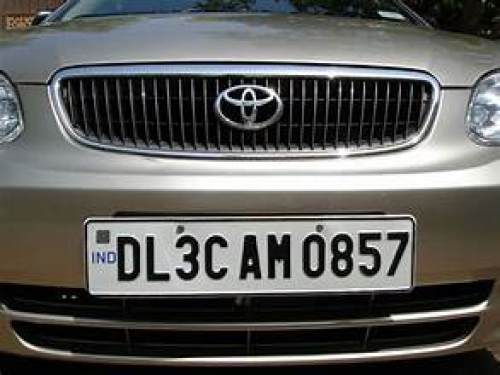

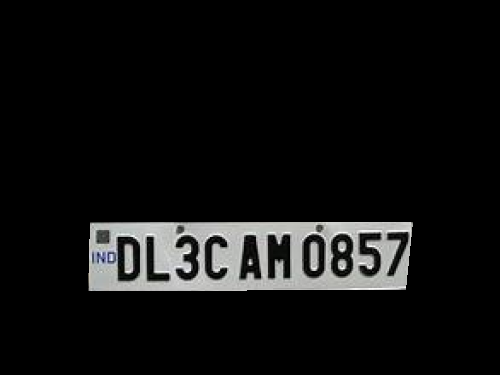

Image 1
"DL3C AM 0857,




In [ ]:
import numpy as np
import os
import datetime
import cv2
import imutils
import pytesseract
import pandas as pd
import random as r
from google.colab.patches import cv2_imshow  # Importing cv2_imshow for displaying images

file_path = 'vehicles.csv'

for i in range(1, 2):
    image = cv2.imread(f'Images/vehicle12.jpg')

    if image is None:
        print(f"Image not found: Images/vehicle12.jpg")
        continue

    image = imutils.resize(image, width=500)
    cv2_imshow(image)  # Display the original image using cv2_imshow

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 170, 200)

    # Find contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and find the largest one that is a quadrilateral
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    NumberPlateCnt = None

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            NumberPlateCnt = approx
            break

    if NumberPlateCnt is None:
        print("Number plate not found")
        continue

    # Masking the part other than the number plate
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [NumberPlateCnt], 0, 255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)
    cv2_imshow(new_image)  # Display the final image using cv2_imshow

    # Configuration for tesseract
    config = ('-l eng --oem 1 --psm 3')

    # Run tesseract OCR on image
    text = pytesseract.image_to_string(new_image, config=config)

    # Generate random times
    hh = r.randint(12, 19)
    mm = r.randint(15, 45)
    intime = f"{hh:02d}:{mm:02d}"

    hh_out = hh + r.randint(1, 3)
    mm_out = mm + r.randint(-6, 13)
    # Adjust for overflow
    if mm_out >= 60:
        hh_out += 1
        mm_out -= 60

    outtime = f"{hh_out:02d}:{mm_out:02d}"

    # Calculate total time
    in_time_obj = datetime.datetime.strptime(intime, '%H:%M')
    out_time_obj = datetime.datetime.strptime(outtime, '%H:%M')
    total_time_obj = out_time_obj - in_time_obj
    total_time_minutes = total_time_obj.total_seconds() / 60  # Convert total seconds to minutes

    raw_data = {
        'Vehicle_Number': [text.strip()],
        'In_Time': [intime],
        'Out_Time': [outtime],
        'Total_Time': [total_time_minutes]  # Store total time in minutes
    }

    df = pd.DataFrame(raw_data, columns=['Vehicle_Number', 'In_Time', 'Out_Time','Total_Time'])

    # Append to CSV file if it exists, otherwise create it
    if os.path.isfile(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, mode='w', header=True, index=False)

    # Print recognized text
    print(f"Image {i}")
    print(text)
    print()